# Imports

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os

import sys
sys.path.insert(1, './../src/')

import time 

import load_option_data_01 

from pathlib import Path

import bsm_pricer as bsm
import config
import datetime
import level_1_filters as f1
import level_2_filters as f2
import level_3_filters as f3
import load_option_data_01 
import load_option_data_01 as l1


import time 
import warnings
import wrds

from scipy.stats import norm, stats
from scipy.spatial.distance import cdist

In [30]:
from scipy import stats

In [2]:
from scipy.stats import shapiro, jarque_bera, normaltest, skew, kurtosis

In [3]:
import importlib

In [4]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"
warnings.filterwarnings("ignore")

In [5]:
OUTPUT_DIR = Path(config.OUTPUT_DIR)
DATA_DIR = Path(config.DATA_DIR)
WRDS_USERNAME = config.WRDS_USERNAME

START_DATE_01 =config.START_DATE_01
END_DATE_01 = config.END_DATE_01

START_DATE_02 =config.START_DATE_02
END_DATE_02 = config.END_DATE_02


In [6]:
DATE_RANGE =f'{pd.Timestamp(START_DATE_01):%Y-%m}_{pd.Timestamp(END_DATE_02):%Y-%m}'

# Functions

In [7]:
# --- Black-Scholes elasticity ---
def bs_elasticity(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d1 - sigma * np.sqrt(T))
        delta = norm.cdf(d1)
    else:
        price = K * np.exp(-r * T) * norm.cdf(-d1 + sigma * np.sqrt(T)) - S * norm.cdf(-d1)
        delta = -norm.cdf(-d1)
    return (delta * S / price), price

# Gaussian kernel function
def kernel_weights(m_grid, ttm_grid, k_s, ttm, bw_m=0.0125, bw_t=10):
    m_grid = np.asarray(m_grid, dtype=float)
    ttm_grid = np.asarray(ttm_grid, dtype=float)
    x = (m_grid - k_s) / bw_m
    y = (ttm_grid - ttm) / bw_t
    dist_sq = x**2 + y**2
    weights = np.exp(-0.5 * dist_sq)
    return weights / weights.sum() if weights.sum() > 0 else np.zeros_like(weights)

# --- Construct a single day portfolio ---
def construct_portfolio(data, k_s_target, ttm_target, option_type='call', r=0.01):
    subset = data[(data['option_type'] == option_type)]
    weights = kernel_weights(subset['moneyness'], subset['ttm'], k_s_target, ttm_target)
    subset = subset.assign(weight=weights)
    subset = subset[subset['weight'] > 0.01]
    subset['weight'] /= subset['weight'].sum()

    # Leverage-adjusted returns
    elast, price = bs_elasticity(
        S=subset['underlying'], K=subset['strike'], T=subset['ttm']/365,
        r=r, sigma=subset['iv'], option_type=option_type
    )
    subset['leverage_return'] = subset['daily_return'] / elast

    return (subset['leverage_return'] * subset['weight']).sum()

# --- Main Loop (simplified) ---
def build_portfolios(option_data, m_grid, ttm_grid, option_types=['call', 'put']):
    portfolios = []
    for opt_type in option_types:
        for k_s in m_grid:
            for ttm in ttm_grid:
                ret = construct_portfolio(option_data, k_s, ttm, option_type=opt_type)
                portfolios.append({
                    'type': opt_type,
                    'moneyness': k_s,
                    'ttm': ttm,
                    'return': ret
                })
    return pd.DataFrame(portfolios)

def calc_kernel_weights(spx_mod):
    """ Calculate kernel weights for each option in the SPX dataset based on moneyness and maturity targets.
    This function iterates through predefined moneyness and maturity targets, applies kernel weights to candidate options."""
    
    # Define moneyness and maturity targets from the paper
    moneyness_targets = [0.925, 0.950, 0.975, 1.000, 1.025, 1.050, 1.075, 1.100]
    maturity_targets = [30, 60, 90]
    cp_flags = ['C', 'P']

    # Preprocess base DataFrame
    spx_mod['days_to_maturity_int'] = spx_mod['days_to_maturity'].dt.days
    spx_mod = spx_mod.reset_index()
    spx_mod['original_index'] = spx_mod.index

    weight_results = []

    # Iterate through each strategy target
    for cp_flag in cp_flags:
        for target_moneyness in moneyness_targets:
            for target_ttm in maturity_targets:
                # Filter candidate options
                candidate_options = spx_mod[
                    (spx_mod['cp_flag'] == cp_flag) &
                    (spx_mod['moneyness_id'] == target_moneyness) &
                    (spx_mod['maturity_id'] == target_ttm)
                ].copy()

                if candidate_options.empty:
                    continue

                candidate_options['kernel_weight'] = np.nan

                # Apply kernel weights per date
                for date, g in candidate_options.groupby('date'):
                    idx = g.index
                    weights = kernel_weights(
                        g['moneyness'].values,
                        g['days_to_maturity_int'].values,
                        k_s=target_moneyness,
                        ttm=target_ttm
                    )
                    candidate_options.loc[idx, 'kernel_weight'] = weights

                weight_results.append(candidate_options[['original_index', 'kernel_weight']])

    # Merge weights back into spx_mod
    if weight_results:
        all_weights = pd.concat(weight_results).set_index('original_index')
        spx_mod.set_index('original_index', inplace=True)
        spx_mod['kernel_weight'] = all_weights['kernel_weight']
        spx_mod.reset_index(inplace=True)
    else:
        print("No matching options found for any target.")

    spx_mod.drop(columns=['original_index'], inplace=True)
    return spx_mod

In [8]:
def calc_option_delta_elasticity(df):
    df = df.copy()

    T = df['days_to_maturity'].dt.days / 365.
    S = df['close']
    K = df['strike_price']
    r = df['tb_m3'] / 100
    sigma = df['IV']
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    df = df.assign(
        option_delta = np.where(df['cp_flag'] == 'C', norm.cdf(d1), norm.cdf(d1) - 1),
        option_elasticity = lambda x: x['option_delta'] * x['close'] / x['mid_price']
    )
    
    return df


In [9]:
def read_option_data(filename):    
    # Example string interval: '(0.9, 0.95]'
    # Remove whitespace and parse the string into tuples
    def parse_interval_string(s):
        # Handle missing or malformed entries gracefully
        if pd.isnull(s) or not isinstance(s, str):
            return pd.NA  # or np.nan
        s = s.strip().replace('(', '').replace(']', '')
        try:
            left, right = map(float, s.split(','))
            return pd.Interval(left, right, closed='right')
        except ValueError:
            return pd.NA
    
    df = pd.read_parquet(filename)
    
    # restore the 'moneyness_bin' column as intervals
    df['moneyness_bin'] = df['moneyness_bin'].apply(parse_interval_string)
    
    return df

In [10]:
def compute_cjs_return_leverage_investment(spx_mod):
    df = spx_mod.copy()
    df = df.sort_values(['ftfsa_id', 'date'])

    # Lag price
    df['mid_price_lag'] = df.groupby('ftfsa_id')['mid_price'].shift(1)

    # Return and daily risk-free rate
    df['option_return'] = (df['mid_price'] - df['mid_price_lag']) / df['mid_price_lag']
    df['daily_rf'] = df['tb_m3'] / 100 / 252

    # Weighted dollar investment and return contribution
    df['inv_weight'] = df['kernel_weight'] / df['option_elasticity']
    df['inv_return'] = df['inv_weight'] * df['option_return']

    # Group and aggregate
    grouped = df.groupby(['date', 'ftfsa_id'])

    port = grouped.agg(
        total_inv_weight=('inv_weight', 'sum'),
        total_inv_return=('inv_return', 'sum'),
        daily_rf=('daily_rf', 'first'),
        cp_flag=('cp_flag', 'first')
    ).reset_index()

    # Apply CJS logic
    def adjusted_return(row):
        if row['cp_flag'] == 'C':
            return row['total_inv_return'] + (1 - row['total_inv_weight']) * row['daily_rf']
        elif row['cp_flag'] == 'P':
            return -row['total_inv_return'] + (1 + row['total_inv_weight']) * row['daily_rf']
        else:
            return np.nan

    port['portfolio_return'] = port.apply(adjusted_return, axis=1)

    return port


In [11]:
# Function to compute normality metrics
def normality_summary(df):
    summary = []
    for col in df.columns:
        series = df[col].dropna()
        shapiro_p = shapiro(series)[1]
        jb_stat, jb_p = jarque_bera(series)
        normaltest_p = normaltest(series)[1]
        skew_val = skew(series)
        kurt_val = kurtosis(series, fisher=False)
        summary.append({
            "Series": col,
            "Shapiro_p": shapiro_p,
            "JarqueBera_p": jb_p,
            "Normaltest_p": normaltest_p,
            "Skewness": skew_val,
            "Kurtosis": kurt_val
        })
    return pd.DataFrame(summary)

# Execution

In [12]:
# read filtered data
source_file = Path(DATA_DIR / f'spx_filtered_final_{DATE_RANGE}.parquet')
spx_filtered = read_option_data(filename=source_file)
spx_filtered = spx_filtered.reset_index()

# create the moneyness ID from the moneyness_bin column, using the right edge of the interval
spx_filtered['moneyness_id'] = spx_filtered['moneyness_bin'].apply(lambda x: x.right if pd.notnull(x) else np.nan)
# drop any rows where moneyness_id is NaN
spx_filtered = spx_filtered.dropna(subset=['moneyness_id'])

spx_filtered

,date,exdate,moneyness,secid,open,close,cp_flag,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,days_to_maturity,pc_parity_int_rate,intrinsic,log_iv,fitted_iv,rel_distance_iv,moneyness_bin,stdev_iv_moneyness_bin,is_outlier_iv,moneyness_id
0,1996-01-04,1996-01-20,0.987534,108105.0,621.32,617.70,C,0.082711,5.04,444.0,5905.0,10.0000,10.375,610.0,100.0,10.18750,16 days,0.015898,7.70,-2.492403,-2.377298,4.841838,"(0.975, 1.0]",3.516840,False,1.000
1,1996-01-04,1996-01-20,1.019913,108105.0,621.32,617.70,C,0.097356,5.04,4022.0,5969.0,1.1875,1.375,630.0,100.0,1.28125,16 days,0.015898,0.00,-2.329381,-2.285771,1.907866,"(1.0, 1.025]",5.219336,False,1.025
2,1996-01-04,1996-01-20,1.028007,108105.0,621.32,617.70,C,0.101756,5.04,1627.0,6224.0,0.6250,0.750,635.0,100.0,0.68750,16 days,0.015898,0.00,-2.285177,-2.264082,0.931727,"(1.025, 1.05]",4.396845,False,1.050
3,1996-01-04,1996-01-20,1.036102,108105.0,621.32,617.70,C,0.100588,5.04,0.0,6593.0,0.1875,0.375,640.0,100.0,0.28125,16 days,0.015898,0.00,-2.296722,-2.242870,2.401027,"(1.025, 1.05]",4.396845,False,1.050
4,1996-01-04,1996-02-17,0.963251,108105.0,621.32,617.70,C,0.071852,5.04,3.0,34.0,25.2500,26.250,595.0,100.0,25.75000,44 days,0.014622,22.70,-2.633147,-2.563785,2.705450,"(0.95, 0.975]",2.301503,False,0.975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195881,2019-12-31,2020-06-19,1.044639,108105.0,3215.18,3230.78,P,0.117063,1.52,0.0,395.0,192.2000,193.000,3375.0,100.0,192.60000,171 days,0.014769,144.22,-2.145043,-2.132215,0.601630,"(1.025, 1.05]",4.396845,False,1.050
3195882,2019-12-31,2020-06-19,1.052377,108105.0,3215.18,3230.78,P,0.113900,1.52,0.0,163.0,208.2000,209.100,3400.0,100.0,208.65000,171 days,0.014769,169.22,-2.172434,-2.165558,0.317525,"(1.05, 1.075]",5.236635,False,1.075
3195883,2019-12-31,2020-06-19,1.060116,108105.0,3215.18,3230.78,P,0.110925,1.52,20.0,310.0,222.8000,228.900,3425.0,100.0,225.85000,171 days,0.014769,194.22,-2.198901,-2.199596,-0.031616,"(1.05, 1.075]",5.236635,False,1.075
3195884,2019-12-31,2020-06-19,1.067854,108105.0,3215.18,3230.78,P,0.108540,1.52,0.0,12.0,241.2000,247.600,3450.0,100.0,244.40000,171 days,0.014769,219.22,-2.220637,-2.234330,-0.612848,"(1.05, 1.075]",5.236635,False,1.075


## Leverage-Adjusted Portfolio Returns Construction Process

The construction of the 27 call and 27 put portfolios in CJS is a multi-step process, with the objective of developing portfolio returns series that are stationary and only moderately skewed. Note that the discrete bucketing of moneyness and days to maturity lead to multiple candidate options for each portfolio on each trading day. These options  are given weights according to a **bivariate Gaussian weighting kernel** in moneyness and maturity (bandwidths: *0.0125 in moneyness* and *10 days to maturity*).

Each portfolio's daily returns are initially calculated as simple arithmetic return, assuming the option is bought and sold at its bid-ask midpoint at each rebalancing. The one-day arithmetic return is then converted to a **leverage-adjusted return**. This procedure is achieved by calculating the one-day return of a hypothetical portfolio with $\omega_{BSM}^{-1}$ dollars invested in the option, and $(1 - \omega^{-1})$ dollars invested in the risk-free rate, where $\omega_{BSM}$ is the BSM elasticity based on the implied volatility of the option. 

\begin{align}
\omega_{\text{BSM, Call}} &= \frac{\partial C_{\text{BSM}}}{\partial S} \cdot \frac{S}{C_{\text{BSM}}} > 1 \\
\omega_{\text{BSM, Put}}  &= \frac{\partial P_{\text{BSM}}}{\partial S} \cdot \frac{S}{P_{\text{BSM}}} < -1
\end{align}

Each **leverage-adjusted call portfolio** comprises of a long position in a fraction of a call, and some investment in the risk-free rate. 

Each **leverage-adjusted put portfolio** comprises of a short position in a fraction of a put, and >100% investment in the risk-free rate. 




<font color="blue">*For clarity, we present below the mathematics behind CJS' descriptions of the portfolio construction process. The following applies for a single trading day $t$, for a set of candidate call or put options, $\{A, B, C\}$. In this dataset, the leverage-adjusted returns of each portfolio would refer to the return of a changing set of candidate options that would qualify for each of the 54 portfolios on each trading day.*</font>

#### 1. Gaussian Kernel Weighting

Let:

* $m_{i}$ = moneyness of option $i$
* $\tau_{i}$ = days to maturity of option $i$
* $k_{s}$ = target moneyness
* $\tau$ = target maturity
* $h_{m}$, $h_{\tau}$ = bandwidths for moneyness and maturity
* $d_{i}^2 = \left( \frac{m_{i} - k_{s}}{h_{m}} \right)^2 + \left( \frac{\tau_{i} - \tau}{h_{\tau}} \right)^2$

Then the unnormalized Gaussian weight for option $i$ is:

$$
w_{i}^* = \exp\left( -\frac{1}{2} d_{i}^2 \right)
$$

The normalized kernel weight:

$$
w_{i} = \frac{w_{i}^*}{\sum_j w_j^*}
$$

---

#### 2. Option Elasticity

Let:

* $S_{t}$ = underlying index level at time $t$
* $P_{i}$ = price of option $i$
* $\Delta_{i}$ = option delta

Then:

$$
\varepsilon_{i} = \frac{S_t \cdot \Delta_{i}}{P_{i}}
$$

---

#### 3. Arithmetic Return of Option $i$

Let:

* $P_{i,t-1}$ = price of option $i$ at time $t-1$
* $P_{i,t}$ = price of option $i$ at time $t$

Then:

$$
r_{i} = \frac{P_{i,t} - P_{i,t-1}}{P_{i,t-1}}
$$

---

#### 4. Leverage-Adjusted Portfolio Construction

Let:

* $r_{f}$ = risk-free rate on day $t$

The leverage-adjusted return of the call portfolio is:

$$
R_t^{call} = \sum_{i} w_{i} \cdot \frac{1}{\varepsilon_{i}} \cdot r_{i} + \left(1 - \sum_{i} w_{i} \cdot \frac{1}{\varepsilon_{i}} \right) \cdot r_f
$$

The leverage-adjusted return of the put portfolio is:

$$
R_t^{put} = -\sum_{i} w_{i} \cdot \frac{1}{\varepsilon_{i}} \cdot r_{i} + \left(1 + \sum_{i} w_{i} \cdot \frac{1}{\varepsilon_{i}} \right) \cdot r_f
$$



Below we implement this process. 

### 1. Build the FTSFA ID for each portfolio

In [13]:
# identify the maturity ID based on the closest maturity to 30, 60, or 90 days
maturity_id = pd.concat((abs(spx_filtered['days_to_maturity'].dt.days - 30), abs(spx_filtered['days_to_maturity'].dt.days - 60), abs(spx_filtered['days_to_maturity'].dt.days - 90)), axis=1)
maturity_id.columns = [30, 60, 90]
spx_filtered['maturity_id'] = maturity_id.idxmin(axis=1)
spx_filtered['ftfsa_id'] = spx_filtered['cp_flag'] + '_' + (spx_filtered['moneyness_id']*1000).apply(lambda x: str(int(x)) if pd.notnull(x) and x == int(x) else str(x)) \
    + '_' + spx_filtered['maturity_id'].astype(str)

# set index to ftfsa_id and date
spx_filtered.set_index(['ftfsa_id', 'date'], inplace=True)
spx_filtered

exdate  moneyness     secid     open    close  \
ftfsa_id  date                                                           
C_1000_30 1996-01-04 1996-01-20   0.987534  108105.0   621.32   617.70   
C_1025_30 1996-01-04 1996-01-20   1.019913  108105.0   621.32   617.70   
C_1050_30 1996-01-04 1996-01-20   1.028007  108105.0   621.32   617.70   
          1996-01-04 1996-01-20   1.036102  108105.0   621.32   617.70   
C_975_30  1996-01-04 1996-02-17   0.963251  108105.0   621.32   617.70   
...                         ...        ...       ...      ...      ...   
P_1050_90 2019-12-31 2020-06-19   1.044639  108105.0  3215.18  3230.78   
P_1075_90 2019-12-31 2020-06-19   1.052377  108105.0  3215.18  3230.78   
          2019-12-31 2020-06-19   1.060116  108105.0  3215.18  3230.78   
          2019-12-31 2020-06-19   1.067854  108105.0  3215.18  3230.78   
P_1100_90 2019-12-31 2020-06-19   1.075592  108105.0  3215.18  3230.78   

                     cp_flag        IV  tb_m3  volume  open_interest  \
ftfsa_id  date                                                         
C_1000_30 1996-01-04       C  0.082711   5.04   444.0         5905.0   
C_1025_30 1996-01-04       C  0.097356   5.04  4022.0         5969.0   
C_1050_30 1996-01-04       C  0.101756   5.04  1627.0         6224.0   
          1996-01-04       C  0.100588   5.04     0.0         6593.0   
C_975_30  1996-01-04       C  0.071852   5.04     3.0           34.0   
...                      ...       ...    ...     ...            ...   
P_1050_90 2019-12-31       P  0.117063   1.52     0.0          395.0   
P_1075_90 2019-12-31       P  0.113900   1.52     0.0          163.0   
          2019-12-31       P  0.110925   1.52    20.0          310.0   
          2019-12-31       P  0.108540   1.52     0.0           12.0   
P_1100_90 2019-12-31       P  0.106814   1.52     0.0            0.0   

                      best_bid  best_offer  strike_price  contract_size  \
ftfsa_id  date                                                            
C_1000_30 1996-01-04   10.0000      10.375         610.0          100.0   
C_1025_30 1996-01-04    1.1875       1.375         630.0          100.0   
C_1050_30 1996-01-04    0.6250       0.750         635.0          100.0   
          1996-01-04    0.1875       0.375         640.0          100.0   
C_975_30  1996-01-04   25.2500      26.250         595.0          100.0   
...                        ...         ...           ...            ...   
P_1050_90 2019-12-31  192.2000     193.000        3375.0          100.0   
P_1075_90 2019-12-31  208.2000     209.100        3400.0          100.0   
          2019-12-31  222.8000     228.900        3425.0          100.0   
          2019-12-31  241.2000     247.600        3450.0          100.0   
P_1100_90 2019-12-31  260.9000     267.500        3475.0          100.0   

                      mid_price days_to_maturity  pc_parity_int_rate  \
ftfsa_id  date                                                         
C_1000_30 1996-01-04   10.18750          16 days            0.015898   
C_1025_30 1996-01-04    1.28125          16 days            0.015898   
C_1050_30 1996-01-04    0.68750          16 days            0.015898   
          1996-01-04    0.28125          16 days            0.015898   
C_975_30  1996-01-04   25.75000          44 days            0.014622   
...                         ...              ...                 ...   
P_1050_90 2019-12-31  192.60000         171 days            0.014769   
P_1075_90 2019-12-31  208.65000         171 days            0.014769   
          2019-12-31  225.85000         171 days            0.014769   
          2019-12-31  244.40000         171 days            0.014769   
P_1100_90 2019-12-31  264.20000         171 days            0.014769   

                      intrinsic    log_iv  fitted_iv  rel_distance_iv  \
ftfsa_id  date                                                          
C_1000_30 1996-01-04       7.70 -2.492403  -2.377298         4.841

In [14]:
spx_filtered['days_to_maturity'].describe()

count                       2676696
mean     56 days 07:55:28.214186444
std      36 days 18:30:26.100585916
min                 7 days 00:00:00
25%                29 days 00:00:00
50%                49 days 00:00:00
75%                74 days 00:00:00
max               180 days 00:00:00
Name: days_to_maturity, dtype: object

### 2. Calculate option elasticity and daily kernel weighting for candidate options for each portfolio. 

In [15]:
spx_mod = spx_filtered.copy()

# calculate option delta and elasticity
spx_mod = calc_option_delta_elasticity(spx_mod)
# calculate daily kernel weights for candidate options
spx_mod = calc_kernel_weights(spx_mod)
spx_mod

,ftfsa_id,date,exdate,moneyness,secid,open,close,cp_flag,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,days_to_maturity,pc_parity_int_rate,intrinsic,log_iv,fitted_iv,rel_distance_iv,moneyness_bin,stdev_iv_moneyness_bin,is_outlier_iv,moneyness_id,maturity_id,option_delta,option_elasticity,days_to_maturity_int,kernel_weight
0,C_1000_30,1996-01-04,1996-01-20,0.987534,108105.0,621.32,617.70,C,0.082711,5.04,444.0,5905.0,10.0000,10.375,610.0,100.0,10.18750,16 days,0.015898,7.70,-2.492403,-2.377298,4.841838,"(0.975, 1.0]",3.516840,False,1.000,30,0.805272,48.826136,16,4.123556e-01
1,C_1025_30,1996-01-04,1996-01-20,1.019913,108105.0,621.32,617.70,C,0.097356,5.04,4022.0,5969.0,1.1875,1.375,630.0,100.0,1.28125,16 days,0.015898,0.00,-2.329381,-2.285771,1.907866,"(1.0, 1.025]",5.219336,False,1.025,30,0.198018,95.465702,16,1.000000e+00
2,C_1050_30,1996-01-04,1996-01-20,1.028007,108105.0,621.32,617.70,C,0.101756,5.04,1627.0,6224.0,0.6250,0.750,635.0,100.0,0.68750,16 days,0.015898,0.00,-2.285177,-2.264082,0.931727,"(1.025, 1.05]",4.396845,False,1.050,30,0.118568,106.529727,16,2.829909e-01
3,C_1050_30,1996-01-04,1996-01-20,1.036102,108105.0,621.32,617.70,C,0.100588,5.04,0.0,6593.0,0.1875,0.375,640.0,100.0,0.28125,16 days,0.015898,0.00,-2.296722,-2.242870,2.401027,"(1.025, 1.05]",4.396845,False,1.050,30,0.058374,128.204965,16,7.170091e-01
4,C_975_30,1996-01-04,1996-02-17,0.963251,108105.0,621.32,617.70,C,0.071852,5.04,3.0,34.0,25.2500,26.250,595.0,100.0,25.75000,44 days,0.014622,22.70,-2.633147,-2.563785,2.705450,"(0.95, 0.975]",2.301503,False,0.975,30,0.960529,23.041498,44,4.015525e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676691,P_1050_90,2019-12-31,2020-06-19,1.044639,108105.0,3215.18,3230.78,P,0.117063,1.52,0.0,395.0,192.2000,193.000,3375.0,100.0,192.60000,171 days,0.014769,144.22,-2.145043,-2.132215,0.601630,"(1.025, 1.05]",4.396845,False,1.050,90,-0.661333,-11.093570,171,5.365533e-16
2676692,P_1075_90,2019-12-31,2020-06-19,1.052377,108105.0,3215.18,3230.78,P,0.113900,1.52,0.0,163.0,208.2000,209.100,3400.0,100.0,208.65000,171 days,0.014769,169.22,-2.172434,-2.165558,0.317525,"(1.05, 1.075]",5.236635,False,1.075,90,-0.700041,-10.839582,171,1.775800e-16
2676693,P_1075_90,2019-12-31,2020-06-19,1.060116,108105.0,3215.18,3230.78,P,0.110925,1.52,20.0,310.0,222.8000,228.900,3425.0,100.0,225.85000,171 days,0.014769,194.22,-2.198901,-2.199596,-0.031616,"(1.05, 1.075]",5.236635,False,1.075,90,-0.737984,-10.556841,171,4.495126e-16
2676694,P_1075_90,2019-12-31,2020-06-19,1.067854,108105.0,3215.18,3230.78,P,0.108540,1.52,0.0,12.0,241.2000,247.600,3450.0,100.0,244.40000,171 days,0.014769,219.22,-2.220637,-2.234330,-0.612848,"(1.05, 1.075]",5.236635,False,1.075,90,-0.773579,-10.226122,171,7.756405e-16


In [16]:
print("Kernel weight check: Should sum to 1.0 for most portfolios on most days.")
spx_mod.groupby(['date', 'ftfsa_id'])['kernel_weight'].sum().round(15).value_counts()

Kernel weight check: Should sum to 1.0 for most portfolios on most days.


kernel_weight
1.0    140476
0.0     16046
Name: count, dtype: int64

***Note**: About 90% of the dataset has kernel weights that sum to 1.0, and 10% has kernel weights that sum to zero. Zero kernel weight for a given portfolio on a given date indicates that there were no candidate options on that particular date that were close to the moneyness and/or maturity targets, leading to all candidate options receiving low (or near-zero) weighting. This assertion needs to be investigated further.*

### 3. Remove options from the portfolio with weights lower than 1%

In [17]:
spx_mod = spx_mod[spx_mod['kernel_weight']>=0.01].reset_index(drop=True)
spx_mod

,ftfsa_id,date,exdate,moneyness,secid,open,close,cp_flag,IV,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,days_to_maturity,pc_parity_int_rate,intrinsic,log_iv,fitted_iv,rel_distance_iv,moneyness_bin,stdev_iv_moneyness_bin,is_outlier_iv,moneyness_id,maturity_id,option_delta,option_elasticity,days_to_maturity_int,kernel_weight
0,C_1000_30,1996-01-04,1996-01-20,0.987534,108105.0,621.32,617.70,C,0.082711,5.04,444.0,5905.0,10.0000,10.375,610.0,100.0,10.18750,16 days,0.015898,7.70,-2.492403,-2.377298,4.841838,"(0.975, 1.0]",3.516840,False,1.000,30,0.805272,48.826136,16,0.412356
1,C_1025_30,1996-01-04,1996-01-20,1.019913,108105.0,621.32,617.70,C,0.097356,5.04,4022.0,5969.0,1.1875,1.375,630.0,100.0,1.28125,16 days,0.015898,0.00,-2.329381,-2.285771,1.907866,"(1.0, 1.025]",5.219336,False,1.025,30,0.198018,95.465702,16,1.000000
2,C_1050_30,1996-01-04,1996-01-20,1.028007,108105.0,621.32,617.70,C,0.101756,5.04,1627.0,6224.0,0.6250,0.750,635.0,100.0,0.68750,16 days,0.015898,0.00,-2.285177,-2.264082,0.931727,"(1.025, 1.05]",4.396845,False,1.050,30,0.118568,106.529727,16,0.282991
3,C_1050_30,1996-01-04,1996-01-20,1.036102,108105.0,621.32,617.70,C,0.100588,5.04,0.0,6593.0,0.1875,0.375,640.0,100.0,0.28125,16 days,0.015898,0.00,-2.296722,-2.242870,2.401027,"(1.025, 1.05]",4.396845,False,1.050,30,0.058374,128.204965,16,0.717009
4,C_975_30,1996-01-04,1996-02-17,0.963251,108105.0,621.32,617.70,C,0.071852,5.04,3.0,34.0,25.2500,26.250,595.0,100.0,25.75000,44 days,0.014622,22.70,-2.633147,-2.563785,2.705450,"(0.95, 0.975]",2.301503,False,0.975,30,0.960529,23.041498,44,0.401552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757525,P_1100_90,2019-12-31,2020-03-31,1.077139,108105.0,3215.18,3230.78,P,0.102622,1.52,0.0,0.0,251.8000,258.300,3480.0,100.0,255.05000,91 days,0.015048,249.22,-2.276703,-2.342683,-2.816445,"(1.075, 1.1]",5.723928,False,1.100,90,-0.911590,-11.547335,91,0.066978
1757526,P_1100_90,2019-12-31,2020-03-31,1.080234,108105.0,3215.18,3230.78,P,0.099399,1.52,0.0,0.0,258.2000,269.200,3490.0,100.0,263.70000,91 days,0.015048,259.22,-2.308613,-2.356986,-2.052300,"(1.075, 1.1]",5.723928,False,1.100,90,-0.927007,-11.357435,91,0.102163
1757527,P_1100_90,2019-12-31,2020-03-31,1.083330,108105.0,3215.18,3230.78,P,0.102206,1.52,0.0,2.0,267.7000,279.600,3500.0,100.0,273.65000,91 days,0.015048,269.22,-2.280765,-2.371357,-3.820268,"(1.075, 1.1]",5.723928,False,1.100,90,-0.929031,-10.968371,91,0.146563
1757528,P_1100_90,2019-12-31,2020-03-31,1.091068,108105.0,3215.18,3230.78,P,0.103736,1.52,0.0,0.0,291.6000,303.600,3525.0,100.0,297.60000,91 days,0.015048,294.22,-2.265906,-2.407588,-5.884824,"(1.075, 1.1]",5.723928,False,1.100,90,-0.943358,-10.241205,91,0.276281


In [18]:
# check elasticity > 1 for call options and < -1 for put options
print("Elasticity > 1 for call options?")
spx_mod[spx_mod['cp_flag']=='C']['option_elasticity'].describe()['min'] > 1.0

Elasticity > 1 for call options?


True

In [19]:
print("Elasticity < -1 for put options?")
spx_mod[spx_mod['cp_flag']=='P']['option_elasticity'].describe()['max'] < -1.0

Elasticity < -1 for put options?


True

### 4. Calculate the daily arithmetic return and the leverage-adjusted return of each portfolio. 

On each trading day, the return of a portfolio is calculated as the <u>weighted average return of the set of candidate options that comprise a single day's option portfolio</u>. The weighting used is the Gaussian kernel weight calculated earlier. Thus the daily return from period $t$ to $t+1$ represents the return from holding a set of candidate options, weighted using the kernel weights as of $t$, from period $t$ to $t+1$. 


In [48]:
portfolio_returns = compute_cjs_return_leverage_investment(spx_mod)

# Preview result
portfolio_returns.set_index(['date', 'ftfsa_id'], inplace=True)

portfolio_returns = portfolio_returns.pivot_table(index='date', columns='ftfsa_id', values='portfolio_return')
portfolio_returns = pd.DataFrame(np.where(portfolio_returns > 1.0, np.nan, portfolio_returns), index=portfolio_returns.index, columns=portfolio_returns.columns)
rets = portfolio_returns.copy()
rets

ftfsa_id,C_1000_30,C_1000_60,C_1000_90,C_1025_30,C_1025_60,C_1025_90,C_1050_30,C_1050_60,C_1050_90,C_1075_30,C_1075_60,C_1075_90,C_1100_30,C_1100_60,C_1100_90,C_925_30,C_925_60,C_925_90,C_950_30,C_950_60,C_950_90,C_975_30,C_975_60,C_975_90,P_1000_30,P_1000_60,P_1000_90,P_1025_30,P_1025_60,P_1025_90,P_1050_30,P_1050_60,P_1050_90,P_1075_30,P_1075_60,P_1075_90,P_1100_30,P_1100_60,P_1100_90,P_925_30,P_925_60,P_925_90,P_950_30,P_950_60,P_950_90,P_975_30,P_975_60,P_975_90
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996-01-04,0.002171,NaN,NaN,0.000198,NaN,NaN,-0.003106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003604,NaN,NaN,0.006069,NaN,NaN,0.000193,NaN,NaN,0.009051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003393,NaN,NaN
1996-01-05,NaN,NaN,NaN,-0.002985,NaN,NaN,0.004674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000760,NaN,NaN,-0.007415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-09,-0.004362,-0.005736,NaN,0.011077,0.000193,NaN,0.039018,0.000195,NaN,0.008154,0.000196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000186,NaN,-0.000977,-0.005790,NaN,0.007256,0.007409,NaN,0.009330,0.000188,NaN,0.009060,0.000186,NaN,0.008965,0.000183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000191,NaN,0.011241,0.007766,NaN
1996-01-10,-0.001291,NaN,NaN,NaN,NaN,NaN,-0.003064,NaN,NaN,-0.005087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002476,NaN,NaN,NaN,NaN,NaN,0.008751,NaN,NaN,-0.015005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-22,-0.002792,NaN,NaN,-0.004186,NaN,NaN,0.004054,NaN,NaN,0.016734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009674,NaN,NaN,0.008213,NaN,NaN,0.008817,NaN,NaN,0.000058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,NaN,NaN,NaN,-0.001959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.000626,0.006539,NaN,NaN,0.006020,0.003000,NaN,NaN,NaN,NaN,NaN,-0.000775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000702,-0.003096,NaN,NaN,0.007690,-0.007144,NaN,NaN
2019-12-26,0.000177,-0.000588,-0.001565,0.049612,0.000451,-0.001096,0.001201,0.000729,NaN,0.001499,-0.000540,-0.001867,NaN,NaN,NaN,-0.000200,-0.000862,-0.001450,-0.000102,-0.000799,-0.001567,0.000011,-0.000786,-0.001644,0.000736,0.001082,0.001069,0.003282,0.001151,0.001065,0.001528,0.001665,NaN,0.001659,0.004004,-0.002207,NaN,NaN,NaN,0.000619,0.000816,0.001072,0.000456,0.000826,0.000696,0.002388,0.000837,0.000776
2019-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000144,-0.001147,NaN,NaN,-0.001185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000463,0.002847,NaN,NaN,0.002921,NaN,NaN,NaN


## Returns Analysis: 

- Discuss Monthly vs Daily differences, and adjustments CJS made for missing prices in the data (not included here)

In [56]:
# choose monthly or daily returns
# CJS used monthly returns, but we can also use daily returns for analysis
use_monthly = True
if use_monthly:
    # Resample to monthly returns
    rets = rets.resample('M').apply(lambda x: (x + 1).prod() - 1)
else:
    # Resample to daily returns
    rets = portfolio_returns.copy()


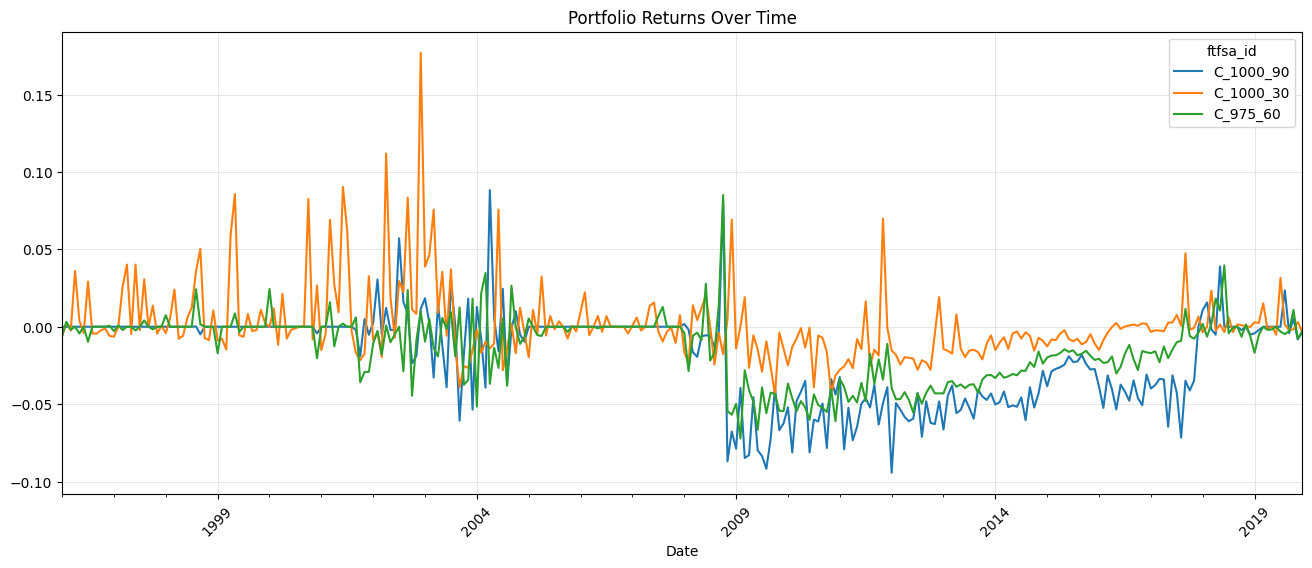

In [57]:
# plot groups of portfolios as line charts
portfolio_list = ['C_1000_90', 'C_1000_30', 'C_975_60', ] #'P_950_30', 'P_1025_60', 'P_950_90'
(rets[portfolio_list]).plot(figsize=(16, 6), title='Portfolio Returns Over Time')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.gca().grid(True, which='major', color='#dddddd', linewidth=0.5)
plt.show()

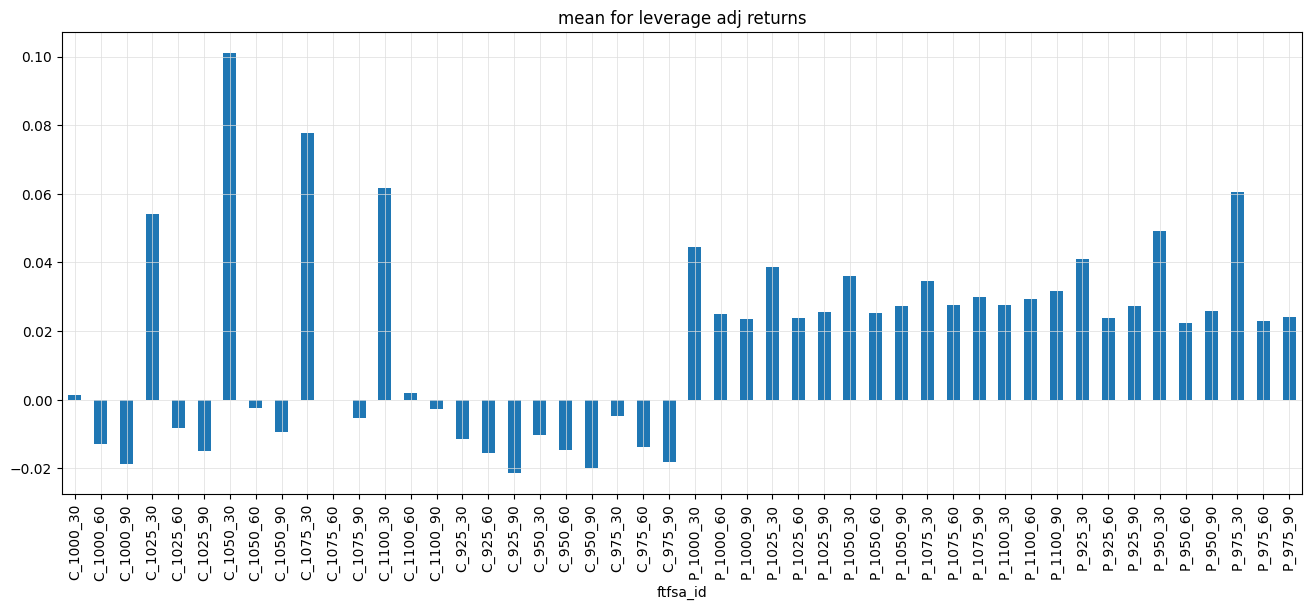

In [58]:
metric = 'mean'
rets.describe().T[metric].plot(kind='bar', figsize=(16, 6), title=f'{metric} for leverage adj returns')
plt.gca().grid(True, which='major', color='#dddddd', linewidth=0.5)

plt.show()

,Series,Shapiro_p,JarqueBera_p,Normaltest_p,Skewness,Kurtosis
0,C_1000_30,1.362858e-19,0.000000e+00,2.080022e-42,2.635524,14.466578
1,C_1000_60,1.282741e-11,4.316206e-16,1.485011e-05,0.194078,5.397047
2,C_1000_90,5.694265e-14,4.874090e-02,4.427849e-02,-0.304341,3.364754
3,C_1025_30,1.894731e-32,0.000000e+00,4.035497e-125,12.435975,185.787169
4,C_1025_60,9.047585e-16,2.002064e-125,4.626920e-21,1.166522,9.512429
5,C_1025_90,7.335767e-12,5.870940e-03,8.244196e-03,-0.358195,3.585727
6,C_1050_30,8.194953e-27,0.000000e+00,7.441562e-76,5.311115,43.407777
7,C_1050_60,2.750242e-22,0.000000e+00,4.772606e-54,3.288743,24.697560
8,C_1050_90,8.842079e-14,2.184393e-22,5.644010e-08,0.471530,5.724560
9,C_1075_30,1.442054e-25,0.000000e+00,1.392264e-60,3.899193,27.417417


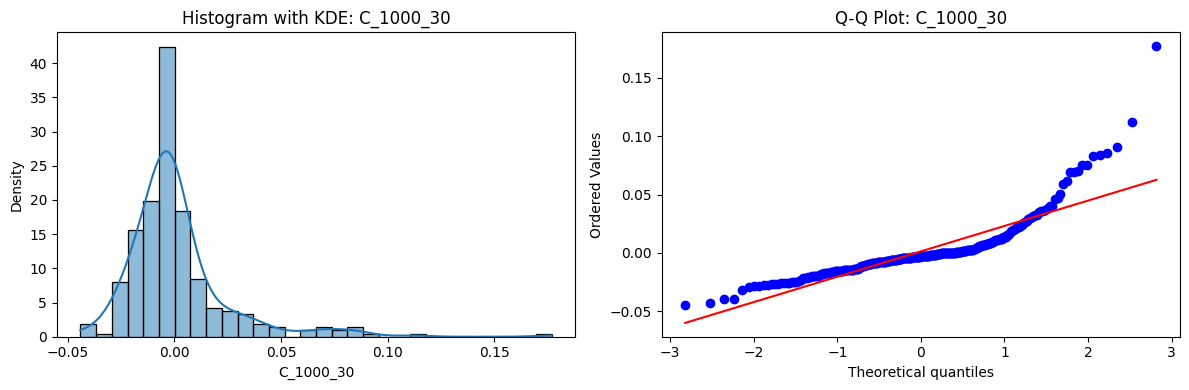

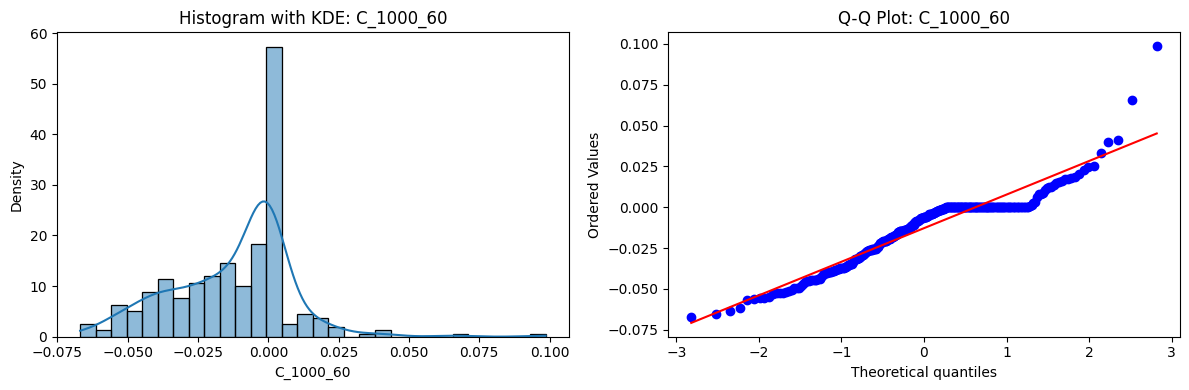

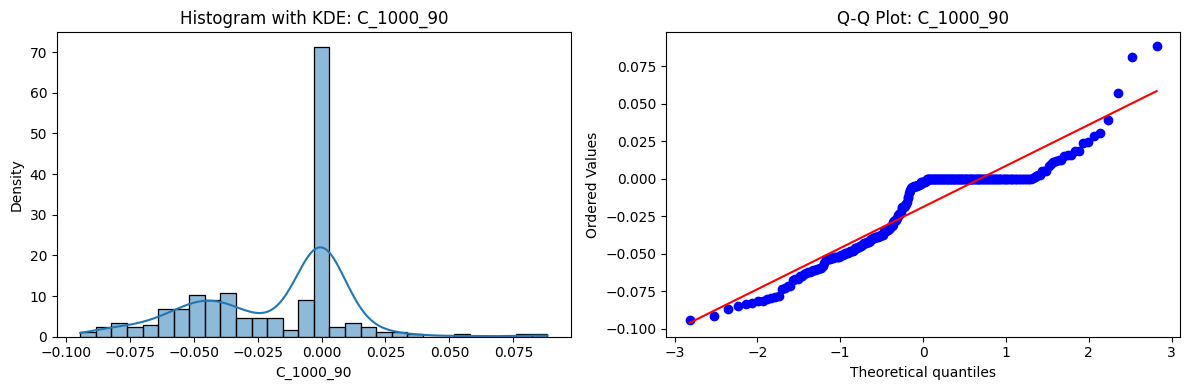

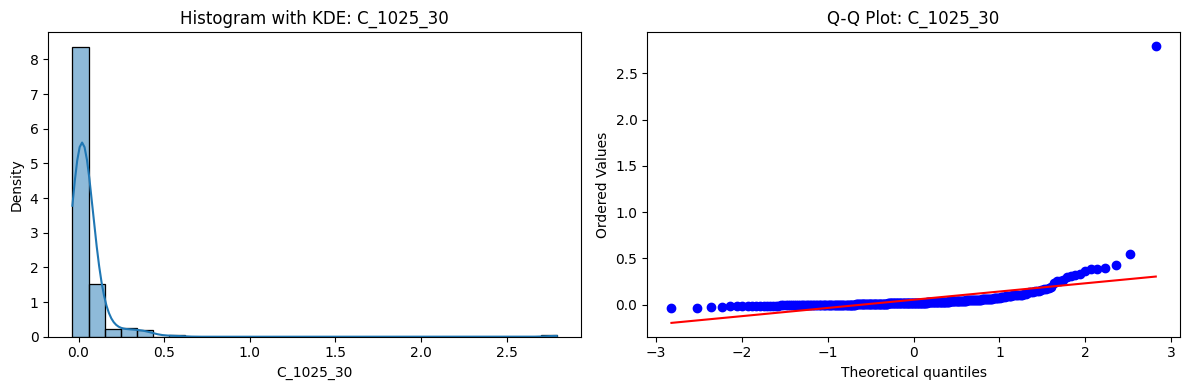

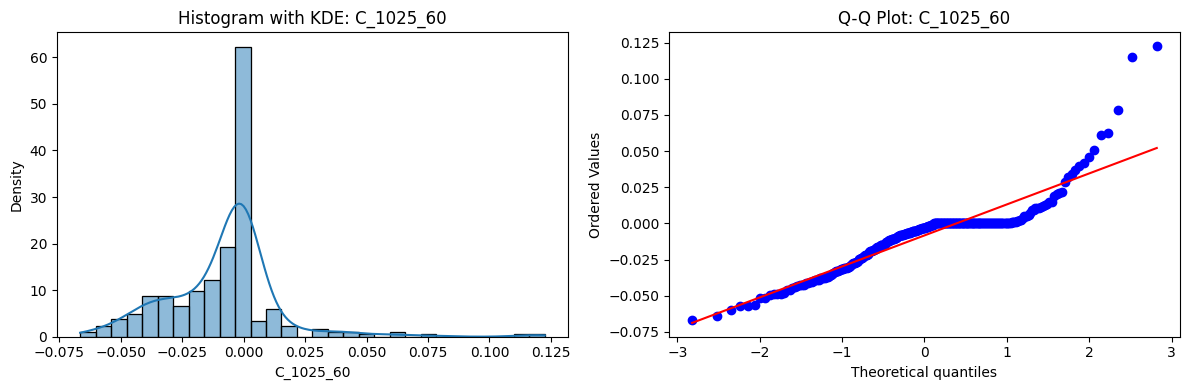

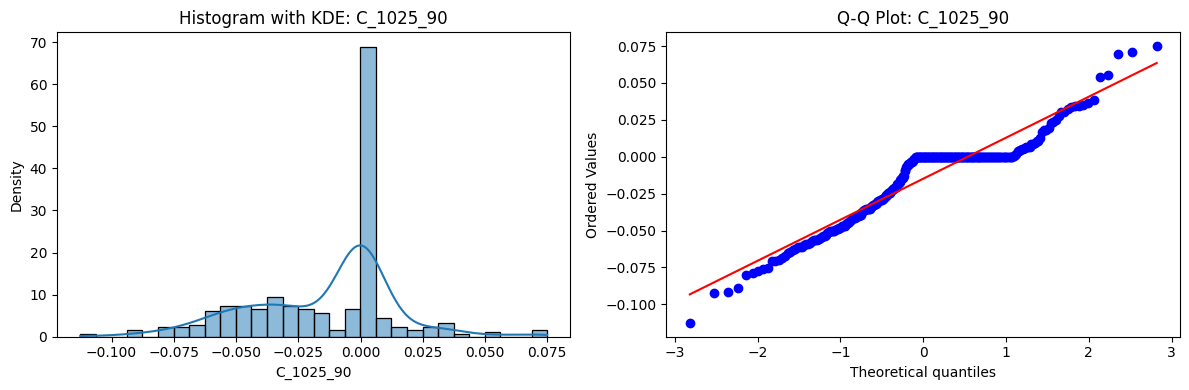

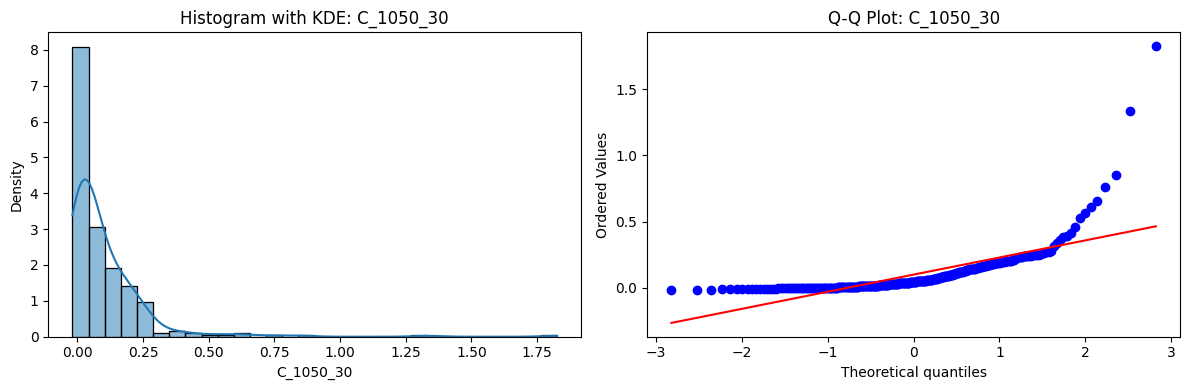

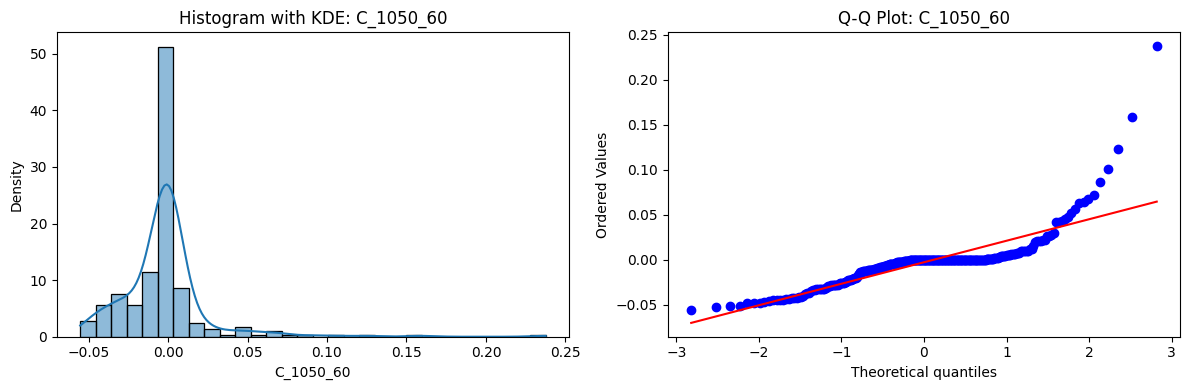

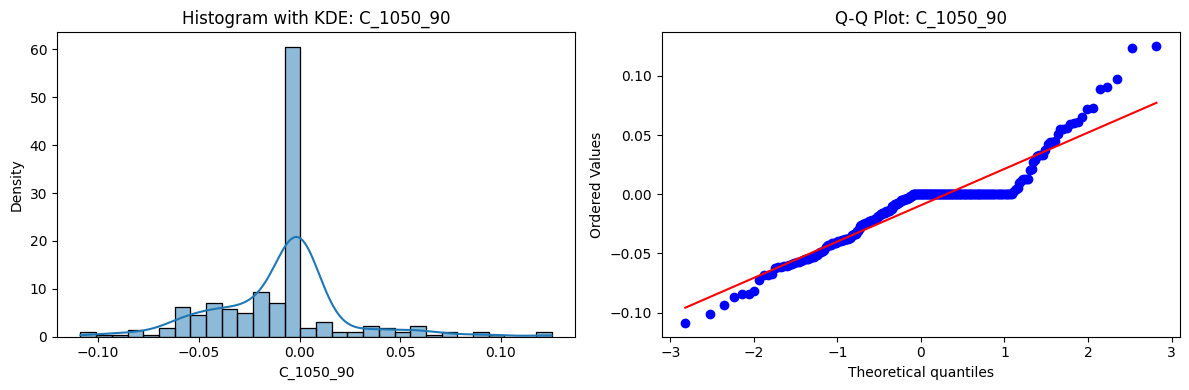

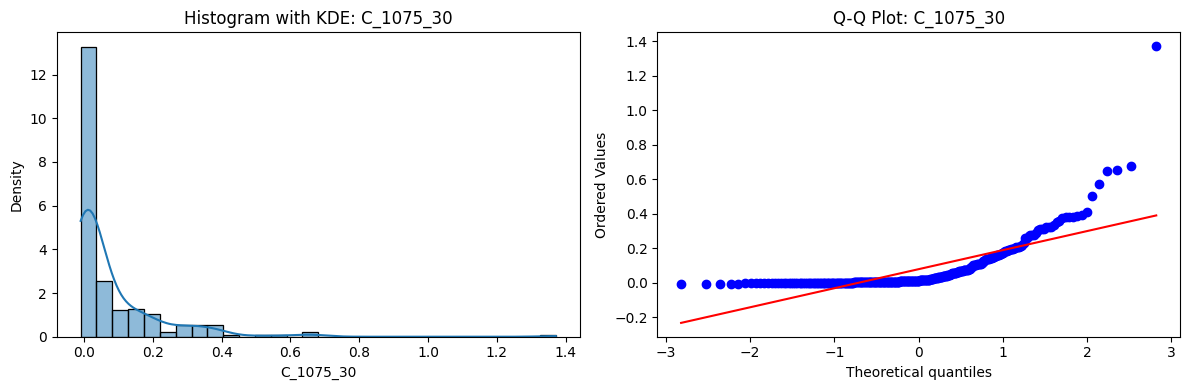

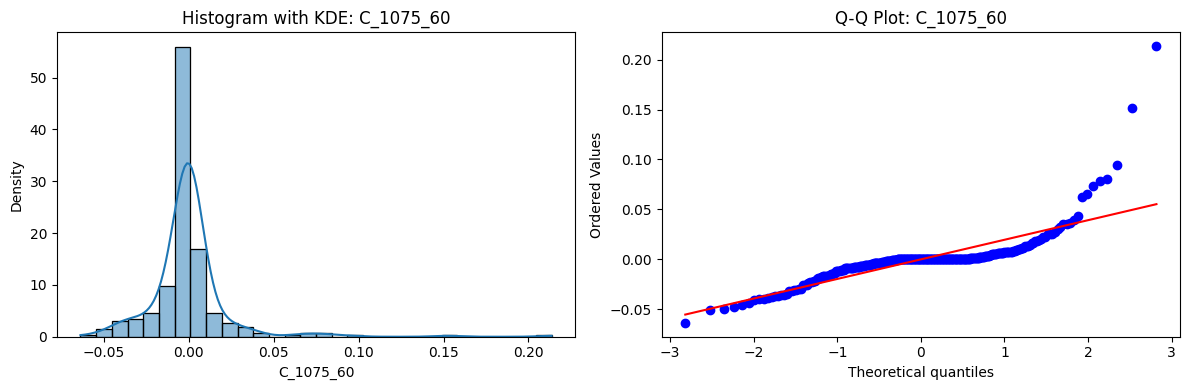

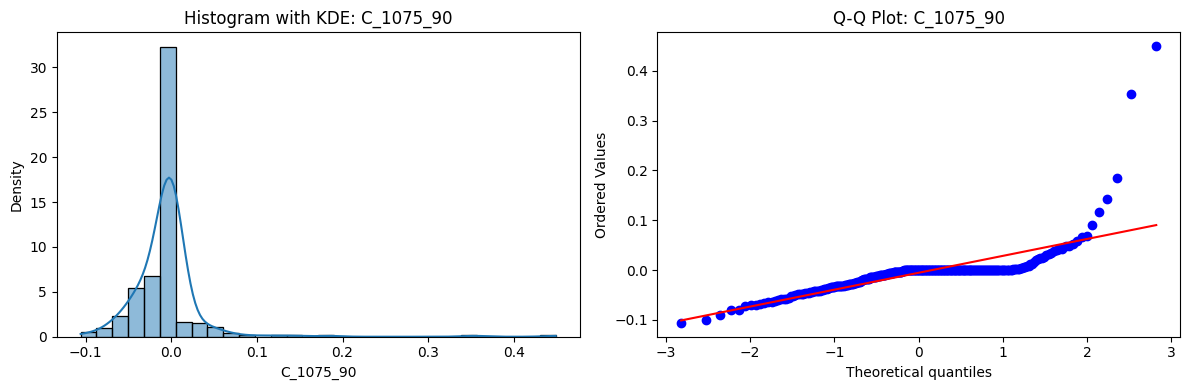

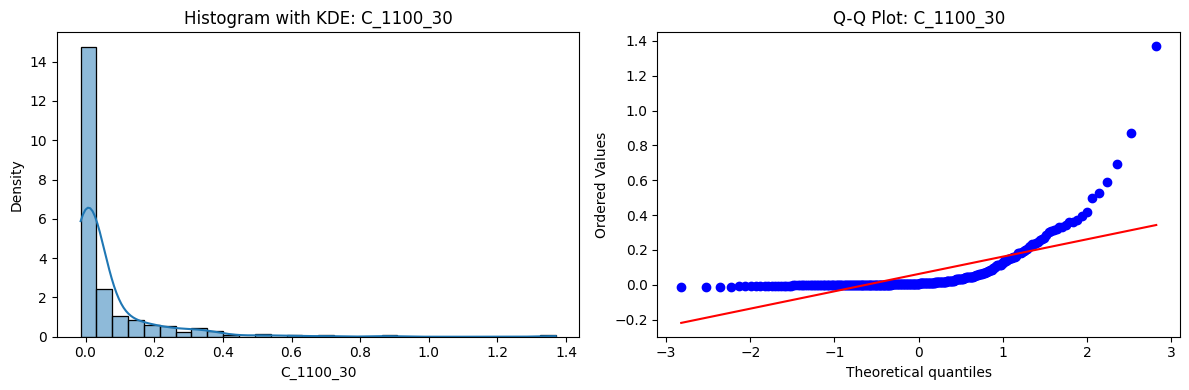

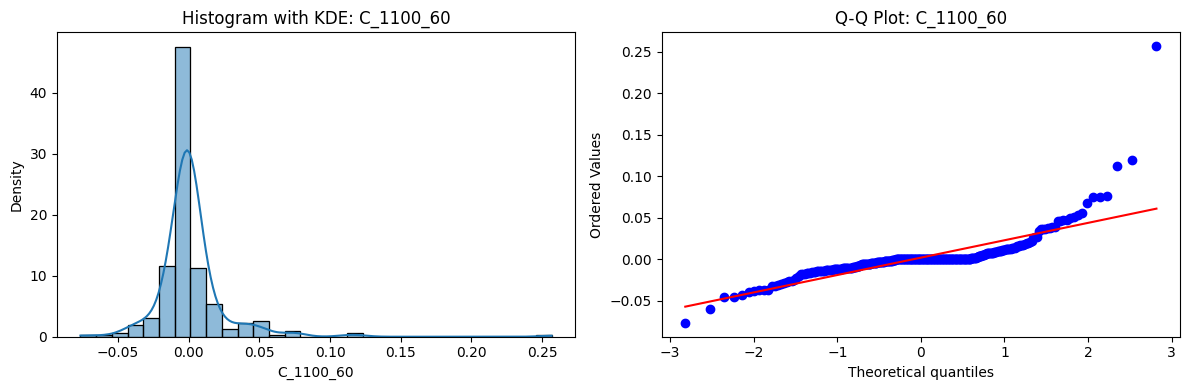

In [ ]:
returns_df = rets.copy()

# Apply to your returns dataframe
summary_df = normality_summary(returns_df)
display(summary_df)

# Plot histogram and QQ plot for each series
for col in returns_df.columns:
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.histplot(returns_df[col].dropna(), kde=True, stat="density", bins=30, ax=axs[0])
    axs[0].set_title(f"Histogram with KDE: {col}")
    
    stats.probplot(returns_df[col].dropna(), dist="norm", plot=axs[1])
    axs[1].set_title(f"Q-Q Plot: {col}")
    
    plt.tight_layout()
    plt.show()


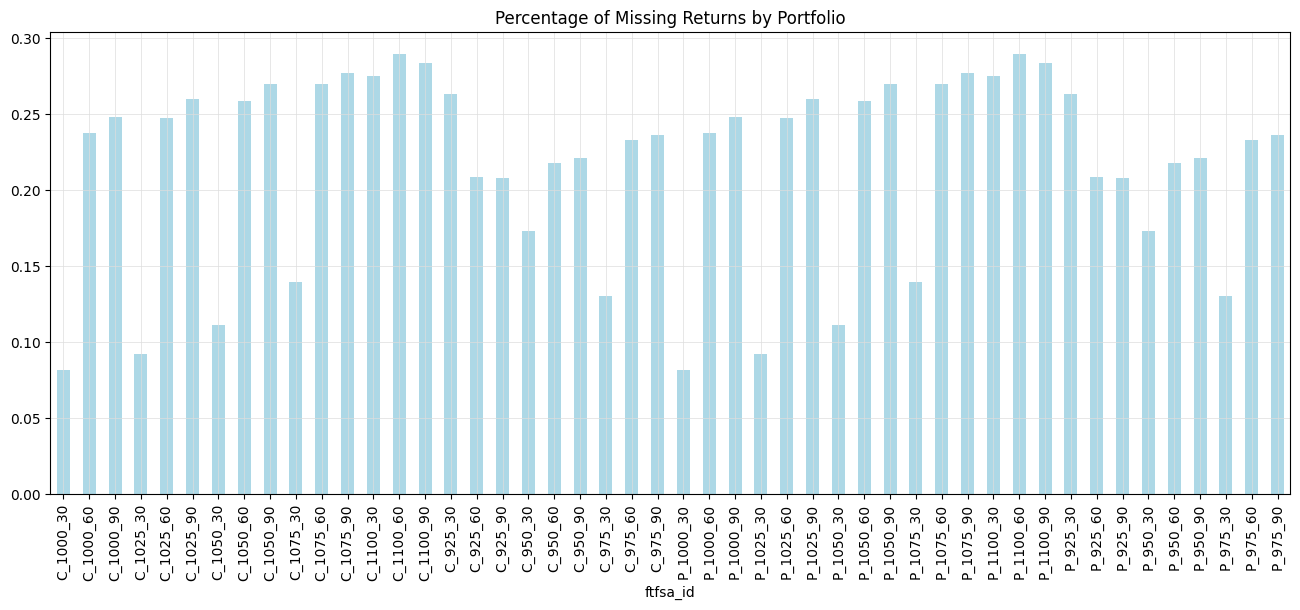

In [ ]:
(rets.isna().sum() / rets.shape[0]).plot(kind='bar', color='lightblue', figsize=(16, 6), title='Percentage of Missing Returns by Portfolio')
plt.gca().grid(True, which='major', color='#dddddd', linewidth=0.5)
plt.show()

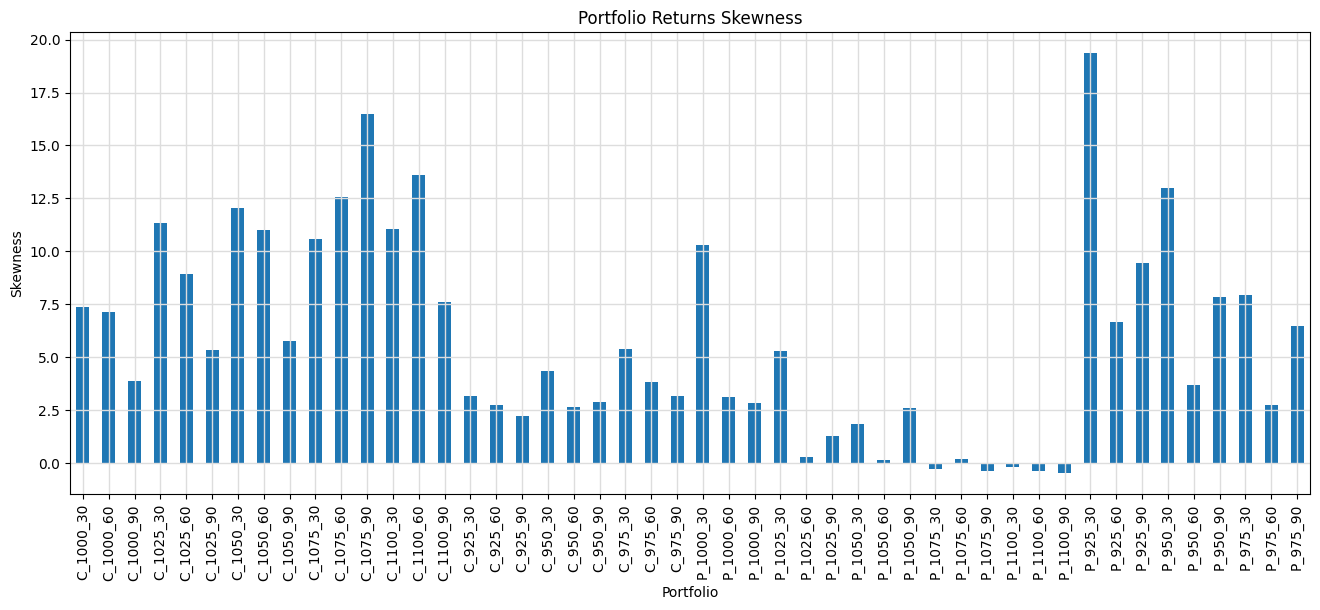

In [ ]:
rets.skew().plot(kind='bar').set_title('Portfolio Returns Skewness')
plt.xlabel('Portfolio')
plt.xticks(np.arange(len(rets.columns)), rets.columns, rotation=90)
plt.gca().grid(True, which='major', color='#dddddd', linewidth=1)
plt.gcf().set_size_inches(16, 6)
plt.ylabel('Skewness')
plt.show()

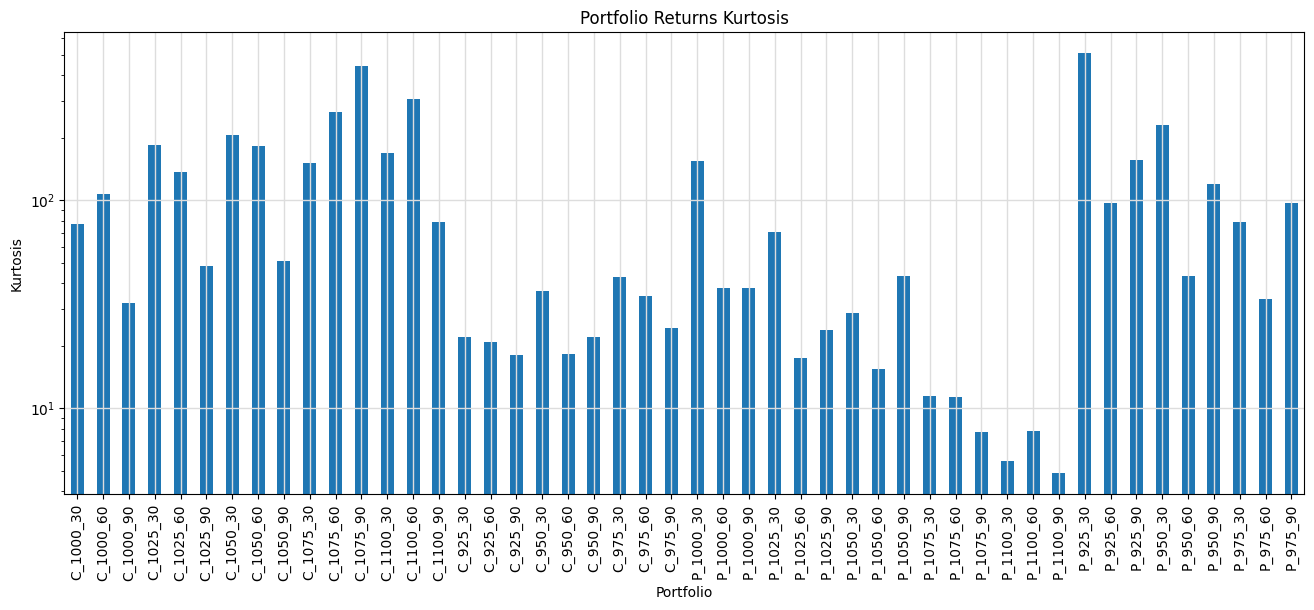

In [ ]:
rets.kurtosis().plot(kind='bar').set_title('Portfolio Returns Kurtosis')
plt.xlabel('Portfolio')
plt.xticks(np.arange(len(rets.columns)), rets.columns, rotation=90)
plt.gca().grid(True, which='major', color='#dddddd', linewidth=1)
plt.gcf().set_size_inches(16, 6)
plt.ylabel('Kurtosis')
plt.yscale('log')
plt.show()

---